# 介绍：

In [ ]:
tag数据为用户标签表，表示用户的年龄，学历等等
trh为交易行为表，是时间序列数据
beh为app行为表，是时间序列数据

目的：
注意，目标变量为tag表中的flag特征，1表示为正样本，0表示为负的样本，因此出题方要求通过建模计算评分数据集中客户的将来出现贷款的违约概率
评价标准指定为AUC


分析：
tag数据集中的许多特征已经做过多种处理（如分桶），因此，数据清洗，特征工程（交互），以及从时间序列数据中提取有效的特征就是关键，
同时应该注意风控模型的特殊之处，它通常要求模型的可解释性也很强，因此神经网络的模型不太适用。

待提升空间：
本次分析没有对tag进行特征工程（交互），也没有对三个表连接后的数据进行encode操作，也没有可视化tag数据进行数据的进一步清洗
（以上均待分析）

提取的特征：
    以beh举例：
        某id：
        （进入页面记录）
        到过所有页面的次数
        到过页面的种类个数
        进入次数最多的那个页面
        对每个页面都计算进入该页面的总次数
    根据上面的思路
    编写了一个函数，获得类别数据的四种特征获得方式：对每个id：所有类别次数；出现最多的类别；出现的类别种类数；每个类别各自出现的次数；
    同样的对trd中的类别数据进行上述四个函数的操作
    对于trd中的数值型数据则关注于提取它的统计量：每个id下的最大值，最小值，均值，中位数，方差，极差等等
    对tag表，则做了适当的数据清洗（不够深入，没有可视化观察，没有取log，没有对上下限判断）

最终结果显示比较重要的特征：
根据xgb的plot_importance判断特征重要性(降序，只列出了10个)：
    
    trd中的交易金额最大值，tag中持有本行信用卡天数 ,trd中的交易金额方差,trd中收支二级分类309类别出现的次数,trd中的交易金额均值
,持有本行借记卡天数,trd中的交易金额最小值，trd中支付方式为B的次数，trd中收支二级分类310类别出现的次数,trd中收支二级分类308类别出现的次数

（也可以通过Logisitic模型的系数绝对值大小判断，解释性更强。这里的特征重要性强表示该特征区分两个类别的能力强）

In [ ]:
总结：
1.特征提取非常重要，好的特征和数据决定了模型的上限，模型的调参只是在逼近这一个上限
2.可以利用模型的一些随机特征（比如xgboost的subsample）的随机性，设定不同的随机种子（用于训练干个模型）将验证集表现最好的那个模型，作为最后要使用的模型。

3.编写了数个关于时间序列数据提取特征的函数：
对于数值型特征，可以提取：
某个id在这个特征上的方差，均值，极大值极小值，中位数（num_attr_stat）

对于分类型特征，可以提取：
每个id下出现了的类别种类数（sample_cat_sum），
每个id各个类别各自出现次数（cat_each_sum），
每个id下的总个数（包括所有类别）（sample_sum），每个id出现类别的众数（cat_most_fre）

对于类别型特征的提取，在这里要注意，训练数据提取出来的特征可能和测试数据提取出来的特征不一样，因为可能某个特征的类别在训练数据（或者测试数据）出现过，但是在测试数据（训练数据）中未出现，造成“各个类别各自出现次数”这一函数的结果不一致，给后面的标准化，onehot，空值填充等预处理操作造成麻烦，所以要让训练数据和测试数据的特征保持一致才行。

另外，onehot的时候，要让测试数据也训练数据合在一起onehot后再分开，否则分别onehot的话两边的同个类别特征出现的类别不一致，
会造成两个数据预处理后不一致。
当然了，如果你可以保证在训练数据里的类别型特征出现的那些类别已经包含了所有情况（不会有一些类别（或者特征）在测试集里面出现而训练集里面没有出现），
那么可以直接对测试集使用.transform()方法，不用将其和训练集连在一起进行fit_transform()

4.模型的参数搜索思路（以xgboost为例）：
第一步：
先搜索使得模型拟合程度越来越高的参数，如增大n_estimators和max_depth（可以一起调整，也可以分别调整），一直到模型表现下降位置（开始过拟合）
第二步：开始减少过拟合。调整帮助模型正则化的相关参数使得过拟合程度下降，具体有subsample，colsample_bytree，gamma和learning_rate等等。

选择最佳参数的时候，不知道该参数的具体合适范围可以使用随机CV结合重尾分布（如对数均匀分布）来找合适的调参区域。
找到合适的调参区域后，在该区域内使用网格cv搜索，而搜索往往因为计算能力的不足很难找到全局最优参数组合，因此可以在这里可以学习分类树的分裂思路，
使用“类贪心法”来调整参数：每次都同时搜索各个参数，比较他们最好的auc，选择最好的那个auc对应的参数加入模型，然后再对剩下的参数重复上述操作，
直到在调整的参数全部添加进模型之中。

6.特征重要性排序的计算（使用eli5包）
（首先要理解原理）
补充1：目前只能对数值型的特征进行判断，类别型数据由于onehot后特征稀疏化了，不容易处理
补充1.1:现在使用OneHotEncoder的get_feature_names函数可以帮助同时判断类别型变量和数值型变量的重要性了。

补充2：eli5.show_weights的top参数，top = n 可以帮助查找对模型贡献的前n名
补充3：删除了对模型有负贡献的特征，模型确实有所提升。
        但是继续删除对模型看起来贡献为0的特征，可能会对模型有负面影响（表现更差了，在本项目中出现了这个情况）。
        因此不见得减少贡献为0的特征对模型就有好处（虽然看起来好像在不影响模型性能的前提下减少了模型复杂度）

In [2]:
import numpy as np
import pandas as pd

In [ ]:
#读取训练数据
data_tag = pd.read_csv("训练数据集_tag.csv",index_col = [0])
data_tag = data_tag.drop("flag",axis = 1)[:]
data_beh = pd.read_csv("训练数据集_beh.csv",index_col = [0])
data_trd = pd.read_csv("训练数据集_trd.csv",index_col = [0])
#获取目标变量
data_tag_y = data_tag.flag[:]
#评分数据集
test_tag = pd.read_csv("评分数据集_tag.csv",index_col = [0])

In [5]:
#从id数目上看，data_tag的最全，可以看出有相当多的人没有访问过页面（beh），也没有做过交易（trd）
len(data_tag.index.unique()),len(data_beh.index.unique()),len(data_trd.index.unique())

(39923, 11913, 31993)

In [6]:
data_trd.head()

,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
id,,,,,,,
UFDC88A,0,B,B,1,116,2019-06-20 07:15:28,-127.99
UFDC88A,0,B,B,1,116,2019-06-16 10:09:13,-55.88
UFDC88A,0,B,B,1,136,2019-05-14 16:11:32,-557.00
UFDC88A,0,B,B,1,136,2019-05-19 21:54:40,-77.80
UFDC88A,0,B,B,1,113,2019-06-18 08:23:59,-271.62


In [27]:
data_beh.head()

,flag,page_no,Unnamed: 3,page_tm
id,,,,
U64F0C9,0,SZA,2019-06-30 12:44:27,NaN
U64F0C9,0,CQE,2019-06-25 16:15:11,NaN
U64F0C9,0,AAO,2019-06-30 12:44:17,NaN
U64F0C9,0,CQE,2019-06-17 13:50:12,NaN
U64F0C9,0,AAO,2019-06-17 13:50:08,NaN


# 从beh提取特征

In [5]:
#各个id进入页面的次数，有的id为0次,计划此列加入模型
page_no_num = data_beh["page_no"].groupby("id").count()
page_sum = pd.Series(page_no_num,name = "visit_page_sum")

In [6]:
#各个id进入的页面种类个数，有的id为0次，计划此列加入模型

#没有将id作为index（没有index_col = [0]），这是为了可以删掉重复行
data_beh_temp = pd.read_csv("训练数据集_beh.csv")
unique_beh = data_beh_temp[["id","page_no"]].drop_duplicates()
page_visit_count = unique_beh.set_index(["id"])
page_visit_count.columns = ["page_visit_count"]
page_visit_count = page_visit_count.groupby("id").count()

In [9]:
#各个id进入次数最多的那个页面，加入到总beh中的时候，有的id没有进入过页面（记录为none），计划此列加入模型
index_num = np.unique(data_beh.index)#取得id
beh_dict = {}

for num in index_num:
        page = pd.Series(data_beh.loc[num].page_no) #取得id到达过哪些页面
        most_fre = page.value_counts().index[0] #取得id到达过的页面中最多次的那个
        dict_temp = {num : most_fre}
        beh_dict.update(dict_temp)
    
beh_most_fre = pd.DataFrame.from_dict(beh_dict,orient = "index") #技巧，将dict转变成DataFrame
beh_most_fre.columns = ["beh_most_fre"]

In [10]:
#构建一个记录每个id进入过哪些页面总次数的表格
page_no_value = data_beh["page_no"].value_counts().index
every_page_no_num = []

for pn in page_no_value:
    #注意不同的pn具有不同长度的列，因为不同的id进入的页面类别不同
    temp = data_beh[data_beh["page_no"] == pn]["page_no"].groupby("id").count()
    pn_name = pn+"_num"
    temp_series = pd.Series(temp,name = pn_name)
    every_page_no_num.append(temp_series)
    
beh_data = pd.DataFrame(index = data_tag.index)
for i in range(len(every_page_no_num)):
    beh_data = pd.merge(beh_data,every_page_no_num[i],how = "outer",left_index = True,right_index = True).fillna(0)      

In [11]:
#加上最开始的访问页面总次数的列,还有访问过页面种类数目的列
beh_data = pd.merge(beh_data,page_sum,how = "outer",left_index = True,right_index = True).fillna(0)
beh_data = pd.merge(beh_data,page_visit_count,how = "outer",left_index = True,right_index = True).fillna(0)
beh_data = pd.merge(beh_data,beh_most_fre,how = "outer",left_index = True,right_index = True).fillna("None")

In [12]:
beh_data.head()

,CQA_num,CQE_num,AAO_num,TRN_num,XAI_num,MSG_num,FTR_num,SZA_num,BWA_num,CTR_num,...,MTA_num,FLS_num,LCT_num,FDA_num,SYK_num,JJD_num,ZY1_num,visit_page_sum,page_visit_count,beh_most_fre
U000101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U00015C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U0001B8,17.0,15.0,14.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.0,7.0,CQA
U00025B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U000437,6.0,3.0,3.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,5.0,CQA


In [ ]:
思考：
对于时间序列型数据，可以写一个函数，自动基于这些特征根据索引，制作新的分组特征

数值型：方差，均值，极大值极小值，中位数
类别型：每个样本下出现了哪些类别（种类数），每个样本各个类别各自出现次数，每个样本下的总个数（包括所有类别），每个样本出现类别的众数

In [13]:
#类别型的相关函数：（即：将beh提取四种特征的方式，函数化）

#返回每个样本下的总个数（包括所有类别）
def sample_sum(data,cat_name,group_by):
    """使用前提，样本的id(或者类似标注）已是这个data的索引"""
    sample_sum = data[cat_name].groupby(group_by).count()
    col_name = cat_name + "_sample_sum" 
    sample_sum = pd.Series(sample_sum,name = col_name)
    return sample_sum
    
#返回每个样本下出现了哪些类别（种类数）
def sample_cat_sum(data,cat_name,group_by):
    """使用前提，样本的id(或者类似标注）已是这个data的索引"""
    data_temp = data.reset_index()
    unique_beh = data_temp[[group_by,cat_name]].drop_duplicates()
    sample_cat_sum = unique_beh.set_index([group_by])
    col_name = cat_name + "sample_cat_sum"
    sample_cat_sum.columns = [col_name]
    sample_cat_sum = sample_cat_sum.groupby(group_by).count()
    return sample_cat_sum

#返回每个样本出现最多次的类别
def cat_most_fre(data,cat_name,group_by):
    """使用前提，样本的id(或者类似标注）是已是这个data的索引
       当连接到总数据的时候，没有众数的样本为None"""
    index_num = np.unique(data.index)
    cat_dict = {}

    for num in index_num:
        cat = pd.Series(data.loc[num][cat_name])
        most_fre = cat.value_counts().index[0]
        dict_temp = {num : most_fre}
        cat_dict.update(dict_temp)
    
    cat_most_fre = pd.DataFrame.from_dict(cat_dict,orient = "index")
    col_name = cat_name + "_most_fre"
    cat_most_fre.columns = [col_name]    
    return cat_most_fre

#返回每个样本各个类别各自出现次数
def cat_each_sum(data,cat_name,group_by,link_data):
    """使用前提，样本的id(或者类似标注）已是这个data的索引"""
    cat_value = data[cat_name].value_counts().index
    each_cat_num = []

    for value in cat_value:
        #不同的value具有不同长度的列，因为不同的样本有不同的类别
        temp = data[data[cat_name] == value][cat_name].groupby(group_by).count()
        col_name =cat_name+"_"+str(value)+"_num"
        temp_series = pd.Series(temp,name = col_name)
        each_cat_num.append(temp_series)
    
    for i in range(len(each_cat_num)):
        link_data = pd.merge(link_data,each_cat_num[i],how = "outer",left_index = True,right_index = True).fillna(0)
    return link_data

# 从trd提取特征

In [130]:
data_trd.head()

,flag,Dat_Flg1_Cd,Dat_Flg3_Cd,Trx_Cod1_Cd,Trx_Cod2_Cd,trx_tm,cny_trx_amt
id,,,,,,,
UFDC88A,0,B,B,1,116,2019-06-20 07:15:28,-127.99
UFDC88A,0,B,B,1,116,2019-06-16 10:09:13,-55.88
UFDC88A,0,B,B,1,136,2019-05-14 16:11:32,-557.00
UFDC88A,0,B,B,1,136,2019-05-19 21:54:40,-77.80
UFDC88A,0,B,B,1,113,2019-06-18 08:23:59,-271.62


In [116]:
#该类别有56个类别
len(data_trd["Trx_Cod2_Cd"].value_counts())

56

In [ ]:
分析：
Dat_Flg1_Cd, Dat_Flg3_Cd, Trx_Cod1_Cd, Trx_Cod2_Cd, 这四个均为类别型数据，其中Trx_Cod2_Cd类别最多，有56个类别
对于类别型数据，分析每个样本一共出现的类别数，各个类别各自出现次数，每个样本出现最多次的那个类别

cny_trx_amt为数值型数据，可以得到某id下该特征的方差，均值，极大值极小值，中位数（因为是交易金额，所以不考虑众数）

类别型数据:（接下来的提取均直接使用上面写的四个函数）

In [14]:
cat_att = ["Dat_Flg1_Cd","Dat_Flg3_Cd","Trx_Cod1_Cd","Trx_Cod2_Cd"]
link_data = pd.DataFrame(index = data_tag.index)
data = data_trd
group_by = "id"
cat_df_set = []
for cat in cat_att:
    cat_df = cat_each_sum(data,cat,group_by,link_data)
    temp1 = sample_sum(data,cat,group_by)
    temp2 = sample_cat_sum(data,cat,group_by)
    temp3 = cat_most_fre(data,cat,group_by)
    cat_df = pd.merge(cat_df,temp1,how = "outer",left_index = True,right_index = True).fillna(0)
    cat_df = pd.merge(cat_df,temp2,how = "outer",left_index = True,right_index = True).fillna(0)
    cat_df = pd.merge(cat_df,temp3,how = "outer",left_index = True,right_index = True).fillna("None")
    cat_df_set.append(cat_df)   

In [15]:
trd_cat_data = pd.merge(cat_df_set[0],cat_df_set[1],left_index = True,right_index = True)
trd_cat_data = pd.merge(trd_cat_data,cat_df_set[2],left_index = True,right_index = True)
trd_cat_data = pd.merge(trd_cat_data,cat_df_set[3],left_index = True,right_index = True)

In [16]:
trd_cat_data.head()

,Dat_Flg1_Cd_B_num,Dat_Flg1_Cd_C_num,Dat_Flg1_Cd_sample_sum,Dat_Flg1_Cdsample_cat_sum,Dat_Flg1_Cd_most_fre,Dat_Flg3_Cd_A_num,Dat_Flg3_Cd_B_num,Dat_Flg3_Cd_C_num,Dat_Flg3_Cd_sample_sum,Dat_Flg3_Cdsample_cat_sum,...,Trx_Cod2_Cd_304_num,Trx_Cod2_Cd_202_num,Trx_Cod2_Cd_106_num,Trx_Cod2_Cd_303_num,Trx_Cod2_Cd_311_num,Trx_Cod2_Cd_212_num,Trx_Cod2_Cd_211_num,Trx_Cod2_Cd_sample_sum,Trx_Cod2_Cdsample_cat_sum,Trx_Cod2_Cd_most_fre
U000101,38.0,14.0,52.0,2.0,B,17.0,35.0,0.0,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,9.0,103
U00015C,8.0,3.0,11.0,2.0,B,0.0,11.0,0.0,11.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,6.0,110
U0001B8,34.0,15.0,49.0,2.0,B,49.0,0.0,0.0,49.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.0,14.0,132
U00025B,37.0,2.0,39.0,2.0,B,1.0,38.0,0.0,39.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,9.0,136
U000437,35.0,11.0,46.0,2.0,B,12.0,34.0,0.0,46.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46.0,13.0,116


数值型数据:

In [17]:
#cny_trx_amt, 方差，均值，极大值极小值，中位数
met = ["var","mean","min","max","median"]
group_by = "id"
data = data_trd
num_att = "cny_trx_amt"

def num_attr_stat(data,num_att,group_by,met):
    if met == "var":
        attr_stat = data[num_att].groupby(group_by).var()
        attr_stat = pd.Series(attr_stat,name = num_att+"_"+met)
    elif met == "mean":
        attr_stat = data[num_att].groupby(group_by).mean()
        attr_stat = pd.Series(attr_stat,name = num_att+"_"+met)
    elif met == "min":
        attr_stat = data[num_att].groupby(group_by).min()
        attr_stat = pd.Series(attr_stat,name = num_att+"_"+met)
    elif met == "max":
        attr_stat = data[num_att].groupby(group_by).max()
        attr_stat = pd.Series(attr_stat,name = num_att+"_"+met)
    elif met == "median":
        attr_stat = data[num_att].groupby(group_by).median()
        attr_stat = pd.Series(attr_stat,name = num_att+"_"+met)       
    return attr_stat

link_data = pd.DataFrame(index = data_tag.index)
for m in met:
    temp = num_attr_stat(data,num_att,group_by,m)
    link_data = pd.merge(link_data,temp,how = "outer", left_index = True,right_index = True).fillna(0)
trd_num_data = link_data[:]

In [18]:
trd_num_data.head()

,cny_trx_amt_var,cny_trx_amt_mean,cny_trx_amt_min,cny_trx_amt_max,cny_trx_amt_median
id,,,,,
U000101,1.029228e+06,-1.417115,-3600.0,3640.00,-3.00
U00015C,6.731997e+07,-2666.363636,-12300.0,12000.00,-6700.00
U0001B8,9.254342e+05,34.591633,-3000.0,3400.00,-6.00
U00025B,1.873301e+07,135.948974,-13843.2,18986.99,-20.00
U000437,7.700249e+07,-349.276522,-20000.0,50000.00,-57.91


# 分析tag数据

In [177]:
data_tag.head()

,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
id,,,,,,,,,,,,,,,,,,,,,
U7A4BAD,M,41,B,B,Z,NaN,3,0,0,0,...,-1,0,0,0,3,1,0,3492,-1,10
U557810,M,35,A,NaN,G,NaN,4,0,0,0,...,-1,0,0,0,1,1,0,4575,-1,10
U1E9240,M,53,B,A,C,C,9,0,0,1,...,-1,0,0,0,7,2,0,4894,-1,40
U6DED00,F,41,B,NaN,Z,NaN,0,0,0,0,...,-1,0,0,0,1,1,0,4938,-1,10
UDA8E28,F,42,B,B,Z,B,3,1,1,1,...,-1,0,0,0,2,7,0,2378,-1,20


In [5]:
test_tag.head()

,gdr_cd,age,mrg_situ_cd,edu_deg_cd,acdm_deg_cd,deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,...,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl
id,,,,,,,,,,,,,,,,,,,,,
UC37930,F,39,B,C,31,~,0,0,0,1,...,20,1,4,NaN,6,3,4,4378,683,20
U5BE130,F,40,B,Z,Z,NaN,1,0,0,1,...,10,0,1,NaN,2,1,1,1078,1637,10
UD025AE,F,48,B,C,31,A,0,0,1,1,...,30,1,5,0.0,7,5,3,6361,4809,20
UC2D00D,M,47,B,A,Z,C,0,0,1,1,...,10,1,5,0.0,7,8,3,8032,5447,40
UAF705D,F,36,B,B,30,~,2,0,0,1,...,20,1,5,NaN,8,4,2,5885,1748,10


In [27]:
#test数据的edu_deg_cd , deg_cd , atdd_type都存在NA
test_tag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, UC37930 to U5573FB
Data columns (total 41 columns):
gdr_cd                             6000 non-null object
age                                6000 non-null int64
mrg_situ_cd                        6000 non-null object
edu_deg_cd                         4148 non-null object
acdm_deg_cd                        6000 non-null object
deg_cd                             2867 non-null object
job_year                           6000 non-null object
ic_ind                             6000 non-null object
fr_or_sh_ind                       6000 non-null object
dnl_mbl_bnk_ind                    6000 non-null object
dnl_bind_cmb_lif_ind               6000 non-null object
hav_car_grp_ind                    6000 non-null object
hav_hou_grp_ind                    6000 non-null object
l6mon_agn_ind                      6000 non-null object
frs_agn_dt_cnt                     6000 non-null object
vld_rsk_ases_ind                   6000 non-null o

In [4]:
#train数据的edu_deg_cd 有1/3均是NA, deg_cd 有1/2都是NA, atdd_type有超过1/2都是NA
data_tag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39923 entries, U7A4BAD to UA5346E
Data columns (total 42 columns):
flag                               39923 non-null int64
gdr_cd                             39923 non-null object
age                                39923 non-null int64
mrg_situ_cd                        39923 non-null object
edu_deg_cd                         27487 non-null object
acdm_deg_cd                        39922 non-null object
deg_cd                             18960 non-null object
job_year                           39923 non-null object
ic_ind                             39923 non-null object
fr_or_sh_ind                       39923 non-null object
dnl_mbl_bnk_ind                    39923 non-null object
dnl_bind_cmb_lif_ind               39923 non-null object
hav_car_grp_ind                    39923 non-null object
hav_hou_grp_ind                    39923 non-null object
l6mon_agn_ind                      39923 non-null object
frs_agn_dt_cnt                     

In [19]:
#将类别数少于20的认定为类别特征
cat_att = []
num_att = []
for col in data_tag.columns:
    length = len(data_tag[col].value_counts())
    if length < 20:
        cat_att.append(col)
    else:
        num_att.append(col)

In [20]:
num_att

['age',
 'job_year',
 'frs_agn_dt_cnt',
 'l12mon_buy_fin_mng_whl_tms',
 'l12_mon_fnd_buy_whl_tms',
 'his_lng_ovd_day',
 'cur_debit_cnt',
 'cur_debit_min_opn_dt_cnt',
 'cur_credit_min_opn_dt_cnt']

num_att的 job_year，frs_agn_dt_cnt，l12mon_buy_fin_mng_whl_tms，l12_mon_fnd_buy_whl_tms，均有不少/N，如何处理？（看看评分训练集是否有）

In [7]:
test_cat_att = []
test_num_att = []
for col in test_tag.columns:
    length = len(test_tag[col].value_counts())
    if length < 20:
        test_cat_att.append(col)
    else:
        test_num_att.append(col)

In [29]:
test_num_att 

['age',
 'job_year',
 'frs_agn_dt_cnt',
 'l12mon_buy_fin_mng_whl_tms',
 'l12_mon_fnd_buy_whl_tms',
 'his_lng_ovd_day',
 'cur_debit_cnt',
 'cur_debit_min_opn_dt_cnt',
 'cur_credit_min_opn_dt_cnt']

In [26]:
#评分训练集也有同训练集一样,很多/N的情况
#for col in test_num_att:
    #print(test_tag[col].value_counts())

因此，决定将所有连续特征的\N都判断为missing_value(缺失值)，而离散特征的/N则作为一个类别来看待

In [21]:
#所有num_data的数字均由str变成int,所有"\\N"都转变成np.nan
#所有cat_data的"\\N"都转变成np.nan(str不变成int，否则onehot会报错)
#这样的操作速度也更快

num_tag = data_tag[num_att]
cat_tag = data_tag[cat_att]

for i in range(num_tag.shape[0]):
    for j in range(num_tag.shape[1]):
        try:
            num_tag.iloc[i,j] = int(num_tag.iloc[i,j])
        except:
            if num_tag.iloc[i,j] == "\\N":
                num_tag.iloc[i,j] = np.nan
            else:
                continue    

for i in range(cat_tag.shape[0]):
    for j in range(cat_tag.shape[1]):
        if cat_tag.iloc[i,j] == "\\N":
            cat_tag.iloc[i,j] = np.nan
        else:
            continue

E:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
#连接tag，beh，trd的所有数据
data_tag_all = pd.merge(num_tag,cat_tag,how = "outer",left_index = True,right_index = True)
data_trd_all = pd.merge(trd_cat_data,trd_num_data,how = "outer",left_index = True,right_index = True)
data_all_prepare = pd.merge(data_tag_all,data_trd_all,how = "outer",left_index = True,right_index = True)
data_all_prepare = pd.merge(data_all_prepare,beh_data,how = "outer",left_index = True,right_index = True)

In [23]:
data_all_prepare.head()

,age,job_year,frs_agn_dt_cnt,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,his_lng_ovd_day,cur_debit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,gdr_cd,...,MTA_num,FLS_num,LCT_num,FDA_num,SYK_num,JJD_num,ZY1_num,visit_page_sum,page_visit_count,beh_most_fre
U000101,32,3,-1,0,0,0,2,709,4291,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U00015C,43,10,-1,0,0,0,1,2276,3529,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U0001B8,29,1,1213,8,14,0,2,1821,1662,M,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,52.0,7.0,CQA
U00025B,49,3,259,0,0,0,2,1676,1357,M,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None
U000437,34,1,989,0,1,0,1,1767,1209,F,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,5.0,CQA


In [25]:
num_att = num_att + [
        'Dat_Flg1_Cd_B_num', 'Dat_Flg1_Cd_C_num', 'Dat_Flg1_Cd_sample_sum',
        'Dat_Flg1_Cdsample_cat_sum',
        'Dat_Flg3_Cd_A_num', 'Dat_Flg3_Cd_B_num', 'Dat_Flg3_Cd_C_num',
        'Dat_Flg3_Cd_sample_sum', 'Dat_Flg3_Cdsample_cat_sum',
        'Trx_Cod1_Cd_1_num', 'Trx_Cod1_Cd_3_num',
        'Trx_Cod1_Cd_2_num', 'Trx_Cod1_Cd_sample_sum',
        'Trx_Cod1_Cdsample_cat_sum', 
        'Trx_Cod2_Cd_136_num', 'Trx_Cod2_Cd_132_num', 'Trx_Cod2_Cd_309_num',
        'Trx_Cod2_Cd_308_num', 'Trx_Cod2_Cd_213_num', 'Trx_Cod2_Cd_111_num',
        'Trx_Cod2_Cd_103_num', 'Trx_Cod2_Cd_102_num', 'Trx_Cod2_Cd_117_num',
        'Trx_Cod2_Cd_134_num', 'Trx_Cod2_Cd_128_num', 'Trx_Cod2_Cd_310_num',
        'Trx_Cod2_Cd_208_num', 'Trx_Cod2_Cd_209_num', 'Trx_Cod2_Cd_104_num',
        'Trx_Cod2_Cd_131_num', 'Trx_Cod2_Cd_116_num', 'Trx_Cod2_Cd_123_num',
        'Trx_Cod2_Cd_112_num', 'Trx_Cod2_Cd_135_num', 'Trx_Cod2_Cd_204_num',
        'Trx_Cod2_Cd_101_num', 'Trx_Cod2_Cd_108_num', 'Trx_Cod2_Cd_113_num',
        'Trx_Cod2_Cd_118_num', 'Trx_Cod2_Cd_133_num', 'Trx_Cod2_Cd_307_num',
        'Trx_Cod2_Cd_130_num', 'Trx_Cod2_Cd_301_num', 'Trx_Cod2_Cd_201_num',
        'Trx_Cod2_Cd_107_num', 'Trx_Cod2_Cd_302_num', 'Trx_Cod2_Cd_125_num',
        'Trx_Cod2_Cd_207_num', 'Trx_Cod2_Cd_129_num', 'Trx_Cod2_Cd_114_num',
        'Trx_Cod2_Cd_110_num', 'Trx_Cod2_Cd_109_num', 'Trx_Cod2_Cd_126_num',
        'Trx_Cod2_Cd_210_num', 'Trx_Cod2_Cd_306_num', 'Trx_Cod2_Cd_205_num',
        'Trx_Cod2_Cd_127_num', 'Trx_Cod2_Cd_122_num', 'Trx_Cod2_Cd_105_num',
        'Trx_Cod2_Cd_115_num', 'Trx_Cod2_Cd_203_num', 'Trx_Cod2_Cd_305_num',
        'Trx_Cod2_Cd_206_num', 'Trx_Cod2_Cd_304_num', 'Trx_Cod2_Cd_202_num',
        'Trx_Cod2_Cd_106_num', 'Trx_Cod2_Cd_303_num', 'Trx_Cod2_Cd_311_num',
        'Trx_Cod2_Cd_212_num', 'Trx_Cod2_Cd_211_num', 'Trx_Cod2_Cd_sample_sum',
        'Trx_Cod2_Cdsample_cat_sum', 
        'cny_trx_amt_var', 'cny_trx_amt_mean', 'cny_trx_amt_min',
        'cny_trx_amt_max', 'cny_trx_amt_median',
        'CQA_num', 'CQE_num', 'AAO_num', 'TRN_num', 'XAI_num', 'MSG_num',
        'FTR_num', 'SZA_num', 'BWA_num', 'CTR_num', 'XAG_num', 'CQD_num',
        'SZD_num', 'CQC_num', 'EGA_num', 'GBA_num', 'CQB_num', 'LC0_num',
        'BWE_num', 'JF2_num', 'JJK_num', 'EGB_num', 'MTA_num', 'FLS_num',
        'LCT_num', 'FDA_num', 'SYK_num', 'JJD_num', 'ZY1_num', 'visit_page_sum',
        'page_visit_count'
        ]
cat_att = cat_att + ['Dat_Flg1_Cd_most_fre','Dat_Flg3_Cd_most_fre','Trx_Cod1_Cd_most_fre','Trx_Cod2_Cd_most_fre','beh_most_fre']

In [197]:
#可以看看列名
#trd_cat_data.columns,trd_num_data.columns,beh_data.columns

In [26]:
num_all_data = data_all_prepare[num_att]
cat_all_data = data_all_prepare[cat_att]
#因为某一分类特征值域有str也有int会报错，所以分为两种情况：
#情况1 ：将Trx_Cod1_Cd_most_fre，Trx_Cod2_Cd_most_fre两列的None改回NA, 用于下面的pipeline，NA会被改成这列的众数
#情况2：将Trx_Cod1_Cd_most_fre，Trx_Cod2_Cd_most_fre两列的None改成某个特别数字（比如-999），用于下面的分类
#（-999作为一个分类，表示这个样本id在时间序列里没有出现）

In [27]:
#目前先只先考虑情况1：
cat_temp = cat_all_data[["Trx_Cod1_Cd_most_fre","Trx_Cod2_Cd_most_fre"]]
for i in range(cat_temp.shape[0]):
    for j in range(cat_temp.shape[1]):
        if cat_temp.iloc[i,j] == "None":
            cat_temp.iloc[i,j] = np.nan
        else:
            continue

cat_all_data["Trx_Cod1_Cd_most_fre"] = cat_temp["Trx_Cod1_Cd_most_fre"]
cat_all_data["Trx_Cod2_Cd_most_fre"] = cat_temp["Trx_Cod2_Cd_most_fre"]

E:\Anaconda\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path wh

In [28]:
#连接分类数据还有训练数据
data_all_prepare = pd.merge(num_all_data,cat_all_data,how = "outer",left_index = True,right_index = True)
all_data = pd.merge(data_all_prepare,data_tag_y,how = "outer",left_index = True,right_index = True)

In [29]:
data_all_prepare.head()

,age,job_year,frs_agn_dt_cnt,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,his_lng_ovd_day,cur_debit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,Dat_Flg1_Cd_B_num,...,l1y_crd_card_csm_amt_dlm_cd,atdd_type,perm_crd_lmt_cd,cur_credit_cnt,cur_debit_crd_lvl,Dat_Flg1_Cd_most_fre,Dat_Flg3_Cd_most_fre,Trx_Cod1_Cd_most_fre,Trx_Cod2_Cd_most_fre,beh_most_fre
U000101,32,3,-1,0,0,0,2,709,4291,38.0,...,1,0,3,1,10,B,B,1,103,None
U00015C,43,10,-1,0,0,0,1,2276,3529,8.0,...,5,0,5,1,10,B,B,1,110,None
U0001B8,29,1,1213,8,14,0,2,1821,1662,34.0,...,1,0,3,1,20,B,A,1,132,CQA
U00025B,49,3,259,0,0,0,2,1676,1357,37.0,...,5,0,7,1,20,B,B,1,136,None
U000437,34,1,989,0,1,0,1,1767,1209,35.0,...,4,0,5,1,10,B,B,1,116,CQA


In [233]:
#预处理的pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer

#处理na值然后标准化
num_tra_pipe = Pipeline([
    ("imputer",SimpleImputer(strategy = "mean",missing_values = np.nan)),
    ("sta_sca",StandardScaler()),    
])

#对离散特征进行onehot
cat_tra_pipe = Pipeline([
    ("imputer",SimpleImputer(strategy = "most_frequent",missing_values = np.nan)),
    ("oh",OneHotEncoder(sparse = False)),
])

num_tra = num_tra_pipe.fit_transform(num_all_data)
cat_tra = cat_tra_pipe.fit_transform(cat_all_data)

In [240]:
prepare_tra_data = np.hstack((num_tra,cat_tra))
data_tag_y = all_data[["data_tag_y"]]

# 分析哪个简单模型（参数均为默认值）效果比较好

In [3]:
#之前已保存的数据，此处不必要运行
#prepare_tra_data = np.load("second_prepare_data.npy",allow_pickle = True)
#data_tag_y = np.load("flag_for_second.npy",allow_pickle = True)

In [7]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(prepare_tra_data,data_tag_y,test_size =0.2,random_state = 42)

***可以使用mean_encode类似的各种encode思路......待分析***

In [5]:
from sklearn.model_selection import cross_val_score

In [250]:
#相对只用了tag数据，加上了时间序列数据的那些特征之后，auc明显上升至0.72
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lo_model = LogisticRegression(random_state = 42)
cv_score = cross_val_score(lo_model,X_train,y_train,cv = 4,scoring = "roc_auc")
cv_score.mean()

E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be chan

0.7234294520922074

In [251]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(random_state = 42)
gbdt_cv = cross_val_score(gbdt,X_train,y_train,cv = 4, scoring = "roc_auc")
gbdt_cv.mean()

E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

0.7427442204269801

In [8]:
import xgboost as xgb
from xgboost import plot_importance

xgboost = xgb.XGBClassifier(random_state = 42)
xgb_cv = cross_val_score(xgboost,X_train,y_train,cv = 4,scoring = "roc_auc")
xgb_cv.mean()

E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

0.7432336229598822

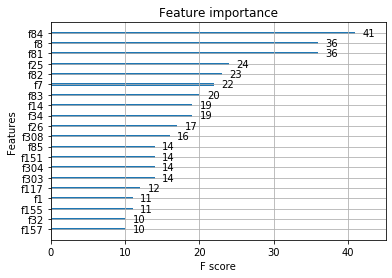

In [17]:
#查看特征重要性
xgb_temp = xgb.XGBClassifier(random_state = 1)
xgb_temp.fit(X_train,y_train)
plot_importance(xgb_temp,max_num_features = 20)